# <center> Introdução à NLP (Processamento de Linguagem Natural)
    
<center> <img src="https://www.fleetscience.org/sites/default/files/images/customer%20ai.gif" width=1000>

<center> Nesta aula, iremos aprender o que é `Processamento de Linguagem Natural`, suas principais aplicações e um repertório de técnicas tanto de `DataPrep` quanto de `Modelagem` para tratar problemas deste tipo!

<center> Nosso principal desafio será o de usar `tweets` para prever se o sentimento da escrita é <b>positivo</b> ou <b>negativo</b> baseado apenas em seus textos, sem que tenhamos que lê-los um a um!

<img src='https://support.appsflyer.com/hc/article_attachments/360001968989/twitter_logo.jpg'>

## 0. Preparativos: Entendendo a base e os dados

Vamos primeiro carregar algumas libs necessárias para os nossos estudos e análises

In [ ]:
# Módulos de manipulação de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Módulos de DataPrep
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Módulos de tratamento de textos
from nltk import word_tokenize, sent_tokenize, RSLPStemmer
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Métricas
from sklearn.metrics import accuracy_score, roc_auc_score

# Módulos de modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

import warnings

warnings.filterwarnings("ignore")

Para este problema, iremos usar cerca de 8 mil `tweets` (1% da base), escritos da maneira que são (ou seja, com hashtags, citações e links)

In [ ]:
# Carregando a base de dados
dados = pd.read_csv(
    "../0. Dados/NoThemeTweets.csv", encoding="utf-8", index_col=0
).sample(frac=0.01, random_state=1234)
print(dados.shape)
dados.head()

(7858, 4)


,tweet_text,tweet_date,sentiment,query_used
id,,,,
1042647383241379841,meu gato beija meu queixo do nada :(,Thu Sep 20 05:31:22 +0000 2018,Negativo,:(
1042621623550058499,acho que meu app de música pifou :( não quer b...,Thu Sep 20 03:49:00 +0000 2018,Negativo,:(
1044172114457251840,"Bom Dia!! Mais um Dia! São September 24, 2018 ...",Mon Sep 24 10:30:06 +0000 2018,Positivo,:)
1039963730069663745,"se cuidem meus príncipes, eu amo vocês :( http...",Wed Sep 12 19:47:29 +0000 2018,Negativo,:(
1041735689115762688,O meu pai só sabe o nome do jungkook e do jimi...,Mon Sep 17 17:08:37 +0000 2018,Negativo,:(


Para simplificar, vamos apenas tomar as colunas importantes, o `tweet_text` e o `sentiment`

In [ ]:
dados = dados[["tweet_text", "sentiment"]].reset_index(drop=True)
dados.head()

,tweet_text,sentiment
0,meu gato beija meu queixo do nada :(,Negativo
1,acho que meu app de música pifou :( não quer b...,Negativo
2,"Bom Dia!! Mais um Dia! São September 24, 2018 ...",Positivo
3,"se cuidem meus príncipes, eu amo vocês :( http...",Negativo
4,O meu pai só sabe o nome do jungkook e do jimi...,Negativo


Temos então o texto do Twitter e o sentimento em duas classes: `Positivo` e `Negativo`, com bom balanceamento entre classes

In [ ]:
dados.sentiment.value_counts(normalize=True) * 100

Negativo    66.11097
Positivo    33.88903
Name: sentiment, dtype: float64

## 1. DataPrep: Como usar textos e palavras como features de modelos?

### 1.0 O primeiro passo: removendo textos indesejados

Apesar de presentes em muitos tweets, certos elementos não fazem parte de um texto contínuo e, portanto, podem nos atrapalhar na hora de avaliar se o texto de um tweet está atrelado a um determinado sentimento. São alguns exemplos:
* Links
* Citações (com @ no início)
* Hashtags (com # no início)
* Smiles :( e :), que por acaso foram usados para definir o sentimento dessa base

Sendo assim, vamos usar um recurso muito conhecido para removê-los: o `RegEx` (Regular Expressions)

`RegEx` é um assunto bastante extenso e poderíamos falar uma aula inteira sobre ele, mas para o momento, o melhor caminho seria usá-lo apenas para simplificar nossa tarefa. Mais para frente deixarei referências sobre o assunto!

In [ ]:
# Definindo os padrões de texto que queremos remover dos textos
regex_urls = "[\s]*http[s]?://\w+(\.com?|\.br)(/\w+)*"
regex_citations = "[\s]*(@\w+)"
regex_hashtags = "[\s]*(#\w+)"
regex_smiles = "[\s]*(:\(|:\)|:D|:P)"

In [ ]:
# Aplicando as remoções usando o comando .str.replace, presente em qualquer string
dados["txt_sem_regex"] = dados.tweet_text.str.replace(regex_urls, "")
dados["txt_sem_regex"] = dados.txt_sem_regex.str.replace(regex_citations, "")
dados["txt_sem_regex"] = dados.txt_sem_regex.str.replace(regex_hashtags, "")
dados["txt_sem_regex"] = dados.txt_sem_regex.str.replace(regex_smiles, "")

In [ ]:
dados.tail(5)

,tweet_text,sentiment,txt_sem_regex
7853,@GusmolinaTwi @liliharmony @sandryyyyyyyy @bea...,Positivo,E vamos lembrar que o Ciro tá ganhando dispar...
7854,@nappyola onde comprei só tinha a E :(,Negativo,onde comprei só tinha a E
7855,Adivinha quem acordou com o diabo do lado? :),Positivo,Adivinha quem acordou com o diabo do lado?
7856,O ze me liga no wpp em grupo c gnt q eu nem co...,Positivo,O ze me liga no wpp em grupo c gnt q eu nem co...
7857,terminar de estudar também :(,Negativo,terminar de estudar também


### 1.1 O conceito de `token`

Até agora, em modelos em que usamos dados `tabulares`, cada informação que usamos para prever uma determinada característica já está devidamente colocada em uma coluna, chamada de `feature`:

<center> <img src = "../2. MISC/tabulardata.png" width=1200>

Mas com texto, esse trabalho fica mais complicado, pois só temos **uma** coluna de features, que é o próprio texto! E mais do que isso, cada texto possui palavras diferentes, então como poderíamos usá-las para diferenciar cada tweet?

In [ ]:
dados.txt_sem_regex.head(15)

0                     meu gato beija meu queixo do nada
1     acho que meu app de música pifou não quer baix...
2     Bom Dia!! Mais um Dia! São September 24, 2018 ...
3                se cuidem meus príncipes, eu amo vocês
4     O meu pai só sabe o nome do jungkook e do jimi...
5                             Não quero nada ir sozinha
6                                         ganda pala e)
7                            Tas a ser, po caralho rude
8                             cuidando do meu bebezinho
9     orgulhinho de mim e deixando de ser mão de vac...
10                                          Ai eu quero
11                                           pior q fui
12                        PQP EU TO MUITO TRISTE(((((((
13    Apaixonada pelas suas sobrancelhas e por vc n ...
14     HUAHAUAHAUAU meu sonho de interiorana era ir ...
Name: txt_sem_regex, dtype: object

É nesses casos em que o conceito de `token`pode nos salvar! O Token nada mais é do que um elemento do texto separado por espaços, o que em quase todos os casos significa uma `palavra`, de fato!

Focando apenas no primeiro registro, vamos ver como poderíamos fazer isso

In [ ]:
primeira_avaliacao = dados.txt_sem_regex.iloc[500]
primeira_avaliacao

'a risadinha'

In [ ]:
# Tipo de dado
type(primeira_avaliacao)

str

Como o tipo de dado é  `string`, podemos usar uma série de métodos inclusos, como, por exemplo, o de separação dos elementos por um determinado separados, o `str.split()`

In [ ]:
primeira_avaliacao.split(" ")

['a', 'risadinha']

Fazendo desta forma, agora temos uma lista onde cada elemento é uma palavra diferente do texto! Cada elemento, portanto, é um  `token` que podemos usar de alguma maneira como feature do nosso modelo

Se quisermos de fato transformar estes `tokens` em features, uma ideia simples seria, por exemplo, contar o número de vezes que cada palavra aparece no texto

In [ ]:
pd.Series(primeira_avaliacao.split(" ")).value_counts()

a            1
risadinha    1
dtype: int64

Se fizéssemos o mesmo processo com o terceiro tweet, teremos contagens diferentes, inclusive com palavras que não foram citadas no primeiro tweet!

In [ ]:
segunda_avaliacao = dados.txt_sem_regex.iloc[3]
pd.Series(segunda_avaliacao.split(" ")).value_counts()

príncipes,    1
amo           1
vocês         1
cuidem        1
se            1
meus          1
eu            1
dtype: int64

Fazer este trabalho apenas com Python puro pode ser complexo, então vamos usar alguns módulos próprioas para estas tarefas!

### 1.2 Funções de tokenização

Temos muitos módulos do Python próprios para esta tarefa de tratamento de texto, e um dos mais famosos é o `NLTK` (**N**atural **L**anguage **T**ool**k**it), que usaremos bastante nessa aula

In [ ]:
# Importando módulos do NLTK
from nltk import word_tokenize, sent_tokenize, RSLPStemmer

Para mostrar algumas funcionalidades, vamos usar algumas expressões de exemplo:

In [ ]:
exemplos_texto = [
    "Eu gosto de correr.",
    "Eu Gosto de corrida",
    "Acho que estou começando a aprender a tratar textos",
    "Esta aula da Tera é sobre NLP, não é?",
]

Para separar palavras em textos usando a função `word_tokenize` do `NLTK`

In [ ]:
for frase in exemplos_texto:
    print(word_tokenize(frase))

['Eu', 'gosto', 'de', 'correr', '.']
['Eu', 'Gosto', 'de', 'corrida']
['Acho', 'que', 'estou', 'começando', 'a', 'aprender', 'a', 'tratar', 'textos']
['Esta', 'aula', 'da', 'Tera', 'é', 'sobre', 'NLP', ',', 'não', 'é', '?']


O que podemos ver desse processo de tokenização?

### 1.3 Transformando nosso Dataset em um `bag of words`

Como vimos com o `word_tokenize` do `NLTK`, podemos separar cada palavra de um texto como elementos de uma lista. Mas para realmente transformarmos estas palavras em `features`, precisamos transformá-las em números de alguma forma.

É nesse tipo de cenário em que podemos usar uma abordagem de `Bag of Words` ou 'saco de palavras', em que a contagem de palavras em cada frase se torna uma coluna.

<img src="https://ichi.pro/assets/images/max/724/1*hLvya7MXjsSc3NS2SoLMEg.png" width=800>

<center> Qual é uma possível desvantagem dessa abordagem?

Vamos então usar o `scikit-learn` para converter todos os textos do nosso exemplo em colunas com as contagens de palavras, usando a função `CountVectorizer`, que além de `tokenizar`as palavras (como o `word_tokenize` do NLTK) também faz para nós a `contagem de palavras em cada tweet`!

Assim como quase todos os objetos do `scikit-learn`, seu funcionamento tem base nos métodos `fit` e `transform`, sendo que o `fit` entende o universo de palavras para transformar em colunas e o `transform` efetivamente faz a transformação

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Instanciando o objeto
cvx = CountVectorizer(
    strip_accents="unicode",  # Tratamento de acentos
    lowercase=True,  # Converte todos os caracteres em letras minúsculas
)

# Ajustando o Count Vectorizer aos dados
cvx.fit(exemplos_texto)
# Aplicando a transformação aos dados
exemplos_tratados = cvx.transform(exemplos_texto)
exemplos_tratados

<4x19 sparse matrix of type '<class 'numpy.int64'>'
	with 22 stored elements in Compressed Sparse Row format>

O resultado é uma `matriz esparsa`, ou seja, com muitos zeros, tantos que vale mais a pena guardar na memória apenas os registros que não são zero. Para converter isso em um `DataFrame` que estamos mais acostumados, temos que usar o método `.todense()` do numpy:

In [ ]:
cvx.fit(exemplos_texto)
exemplos_tratados = cvx.transform(exemplos_texto)
exemplos_tratados = pd.DataFrame(exemplos_tratados.todense())
exemplos_tratados

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0
2,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1
3,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,1,1,0,0


Como convertemos cada palavra distinta em uma coluna, o número de features será proporcional ao vocabulário do texto, que neste caso é de 18 palavras. O objeto `CountVectorizer` também guarda a informação do identificador de cada palavra no parâmetro `vocabulary_`:

In [ ]:
mapa_vocabulario = {v: k for k, v in cvx.vocabulary_.items()}
# Ajustando o nome das colunas
exemplos_tratados.columns = exemplos_tratados.columns.map(mapa_vocabulario)
exemplos_tratados

,acho,aprender,aula,comecando,correr,corrida,da,de,esta,estou,eu,gosto,nao,nlp,que,sobre,tera,textos,tratar
0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0
2,1,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1
3,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,1,1,0,0


O que funcionou bem nesse processo? E o que podemos melhorar?

Para os próximos passos, vamos transformar todo esse processo de `bag of words` em uma função fácil de ser chamada:

In [ ]:
def faz_bagofwords(frases):
    # Instancia o CountVectorizer
    cv_aux = CountVectorizer(strip_accents="unicode", lowercase=True)
    # Ajusta o objeto às frases
    cv_aux.fit(frases)
    # Constrói um Dataframe transformado
    tratados = cv_aux.transform(frases)
    tratados = pd.DataFrame(tratados.todense())
    tratados.columns = tratados.columns.map(
        {v: k for k, v in cv_aux.vocabulary_.items()}
    )
    return tratados

### 1.4 Removendo Stopwords

No nosso processo de `bag of words` da forma atual, estamos incluindo elementos não tão importantes assim para o sentido de um comentário, como:
* Pontuações (virgula, ponto, interrogação)
* Artigos (a)
* Preposições e Apostos (esta, este)

Será que temos alguma forma de retirar essas palavras das sentenças tokenizadas?

Estas palavras não tão importantes são chamadas de `stopwords`, e há uma série de bibliotecas no Python que podem tratá-las. O NLTK tem a sua própria relação de stopwords na língua portuguesa, e ela pode ser baixada 

In [ ]:
# Descomente e rode a célula abaixo caso não tenha o NLTK!
# nltk.download('stopwords')

In [ ]:
# Verificando e salvando as stopwords
stopwords_portugues = nltk.corpus.stopwords.words("portuguese")
stopwords_portugues[:15]

['de',
 'a',
 'o',
 'que',
 'e',
 'é',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'não',
 'uma',
 'os']

Com essa nova lista de palavras, podemos removê-las das expressões tokenizadas usando um `list comprehension`:

In [ ]:
for frase in exemplos_texto:
    print(
        [
            palavra
            for palavra in word_tokenize(frase)
            if palavra not in stopwords_portugues
        ]
    )

['Eu', 'gosto', 'correr', '.']
['Eu', 'Gosto', 'corrida']
['Acho', 'começando', 'aprender', 'tratar', 'textos']
['Esta', 'aula', 'Tera', 'sobre', 'NLP', ',', '?']


Ainda não retiramos as ponuações do texto, mas podemos fazer isso usando um processo similar ao de stopwords, mas agora também considerando os sinais de pontuação

In [ ]:
lista_pontuacoes = [".", ",", "!", "?", ":", ";"]
# Unindo com o que já tinhamos mapeado de stopwords
stopwords_mais_pontuacao = stopwords_portugues + lista_pontuacoes

In [ ]:
for frase in exemplos_texto:
    print(
        [
            palavra
            for palavra in word_tokenize(frase)
            if palavra not in stopwords_mais_pontuacao
        ]
    )

['Eu', 'gosto', 'correr']
['Eu', 'Gosto', 'corrida']
['Acho', 'começando', 'aprender', 'tratar', 'textos']
['Esta', 'aula', 'Tera', 'sobre', 'NLP']


Vamos agora aplicar novamente o `Bag of Words` na nossa nova lista de frases. Para isso, temos que unir as tokens em uma frase novamente, o que pode ser feito usando o método `.join()` de uma string

In [ ]:
lista_exemplo = ["eu", "quero", "unir", "essas", "palavras"]
# Exemplo do uso do 'join'
" ".join(lista_exemplo)

'eu quero unir essas palavras'

In [ ]:
# Construindo a lista de frases novamente, apenas de palavras que não são stopwords
exemplos_stopwords = []
for frase in exemplos_texto:
    exemplos_stopwords.append(
        " ".join(
            [
                palavra
                for palavra in word_tokenize(frase)
                if palavra not in stopwords_mais_pontuacao
            ]
        )
    )

In [ ]:
faz_bagofwords(exemplos_stopwords)

,acho,aprender,aula,comecando,correr,corrida,esta,eu,gosto,nlp,sobre,tera,textos,tratar
0,0,0,0,0,1,0,0,1,1,0,0,0,0,0
1,0,0,0,0,0,1,0,1,1,0,0,0,0,0
2,1,1,0,1,0,0,0,0,0,0,0,0,1,1
3,0,0,1,0,0,0,1,0,0,1,1,1,0,0


O que mudou? E o que persistiu?

No processo de remoção de `stopwords`, acabamos removendo palavras que podem ser úteis na identificação de sentimento, principalmente palavras que indicam negação ou descontentamento, como `não` e `mas`. Para evitar remover essas palavras, podemos incluir uma lista de exclusão, com palavras que não queremos que sejam removidas:

In [ ]:
# Criando uma lista de exceção de palavras para serem consideradas como stopwords
lista_excecao = ["não", "mas", "entretanto", "porém"]
# Atualizando nossa lista de stopwords
stopwords_final = [
    palavra for palavra in stopwords_mais_pontuacao if palavra not in lista_excecao
]

In [ ]:
exemplos_stopwords_excecoes = []
for frase in exemplos_texto:
    exemplos_stopwords_excecoes.append(
        " ".join(
            [
                palavra
                for palavra in word_tokenize(frase)
                if palavra not in stopwords_final
            ]
        )
    )

# Aplica novamente nossa função de bag of words
faz_bagofwords(exemplos_stopwords_excecoes)

,acho,aprender,aula,comecando,correr,corrida,esta,eu,gosto,nao,nlp,sobre,tera,textos,tratar
0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0
1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0
2,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1
3,0,0,1,0,0,0,1,0,0,1,1,1,1,0,0


Agora a palavra `não` foi mantida na última frase!

### 1.5 Capturando a essência das palavras com `stemming`

As palavras `correr` e `corrida` derivam da mesma matriz de palavra, e por conta disso as duas primeiras frases não são realmente diferentes do ponto de vista de `significado`. Sendo assim, como podemos tratar estas palavras apenas pela sua origem  (derivação ou `stem`):

<img src="https://user.oc-static.com/upload/2020/10/22/16033551309054_stemming%20example.png" width=800>

Podemos tratar os prefixos e sufixos em português usando outra função do NLTK, o `RSLPStemmer`:

In [ ]:
# Caso não tenha instalado, descomentar a linha abaixo e rodar!
# nltk.download('rslp')
# Importando o módulo
from nltk import RSLPStemmer

# Instanciando o objeto
stemmer = RSLPStemmer()

Para usar o Stemmer, basta usar o método `.stem()` no token de interesse

In [ ]:
# Aplicando sobre o texto
for frase in exemplos_texto:
    print(
        [
            stemmer.stem(palavra)
            for palavra in word_tokenize(frase)
            if palavra not in stopwords_final
        ]
    )

['eu', 'gost', 'corr']
['eu', 'gost', 'corr']
['ach', 'começ', 'aprend', 'trat', 'text']
['est', 'aul', 'ter', 'sobr', 'nlp', 'não']


Agora as primeiras duas expressões são verdadeiras! Mas nem sempre o stemming pode ser justo com algumas palavras, como com `Tera` que foi reduzida a `ter`, por ser sinônimo de `terá` sem o acento.

Vamos ver como fica o `bag of words` nesse novo exemplo:

In [ ]:
exemplos_stem = []
for frase in exemplos_texto:
    exemplos_stem.append(
        " ".join(
            [
                stemmer.stem(palavra)
                for palavra in word_tokenize(frase)
                if palavra not in stopwords_final
            ]
        )
    )

# Aplicando nossa função de Bag of Words
faz_bagofwords(exemplos_stem)

,ach,aprend,aul,comec,corr,est,eu,gost,nao,nlp,sobr,ter,text,trat
0,0,0,0,0,1,0,1,1,0,0,0,0,0,0
1,0,0,0,0,1,0,1,1,0,0,0,0,0,0
2,1,1,0,1,0,0,0,0,0,0,0,0,1,1
3,0,0,1,0,0,1,0,0,1,1,1,1,0,0


Quais mudanças aconteceram nesse caso?

### 1.6 Aplicando o Dataprep no nosso Dataset

Podemos fazer algumas análises simples e entender quais são os termos mais citados das avaliações positivas e negativas, até mesmo para validar nosso método de tratamento de textos.

Primeiramente vamos aplicar todas as transformações que comentamos no dataset original, `exceto Stemming`, para facilitar a interpretação dos termos, criando uma função que faça todos os processos de uma vez

In [ ]:
def dataprep_texto(texto, excecoes_stopwords=["não", "mas", "porém", "entretanto"]):
    # Define a lista de stopwords
    stopwords = set(
        nltk.corpus.stopwords.words("portuguese") + [".", ",", "!", "?", ":", ";"]
    ) - set(excecoes_stopwords)
    # Realiza a tokenização e a stemmização da frase
    return " ".join(
        [palavra for palavra in word_tokenize(texto) if palavra not in stopwords]
    )

In [ ]:
# Usando a função 'apply' para aplicar nossa função de DataPrep à coluna 'avaliacao'
dados["texto_final"] = dados.txt_sem_regex.apply(dataprep_texto)
dados.head()

# Renomeando colunas (menos a última, que é a target) para facilitar a análise
df_frases = faz_bagofwords(dados.texto_final)
# Incluindo a coluna de sentimento
df_frases["sentimento_tweet"] = dados.sentiment
df_frases.head()

,00,000,00155a7d,00am,00pm,01,01h,03,032f6ace6b16,040,...,zona,zoo,zootopia,zuado,zuando,zuckerberg,zuou,ᅠᅠᅠᅠᅠᅠ,ゝeu,sentimento_tweet
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negativo
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negativo
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positivo
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negativo
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negativo


Vamos verificar os 10 termos mais citados em avaliações positivas e negativas

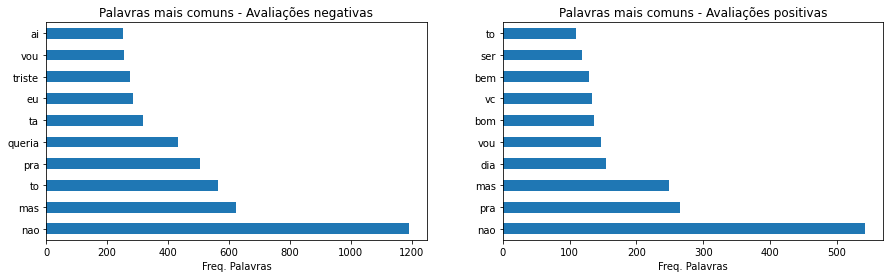

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
cols_palavras = df_frases.columns[:-1]
df_frases[df_frases.sentimento_tweet == "Negativo"][cols_palavras].sum().sort_values(
    ascending=False
)[:10].plot(kind="barh", ax=ax[0])
df_frases[df_frases.sentimento_tweet == "Positivo"][cols_palavras].sum().sort_values(
    ascending=False
)[:10].plot(kind="barh", ax=ax[1])
ax[0].set_xlabel("Freq. Palavras")
ax[1].set_xlabel("Freq. Palavras")
ax[1].set_title("Palavras mais comuns - Avaliações positivas")
ax[0].set_title("Palavras mais comuns - Avaliações negativas")
plt.show()

Apesar de termos algumas palavras similares (`não`, `mas`) nos dois conjuntos, nas avaliações positivas conseguimos ver palavras de conotação positiva (`bom`, `bem`), e nas negativas algumas palavras mais frequentemente associadas com sentimentos negativos (`triste`)

Temos outras formas de representar estes termos, como por exemplo usando a biblioteca `Wordcloud`

In [ ]:
from wordcloud import WordCloud

# Instanciando o objeto
wc = WordCloud(
    max_words=25,  # Número máximo de palavras no wordcloud
    random_state=42,  # Estado aleatório
)

Após instanciarmos o objeto, podemos gerar a nuvem de palavras fornecendo os tweets e o tamanho da imagem

(-0.5, 399.5, 199.5, -0.5)

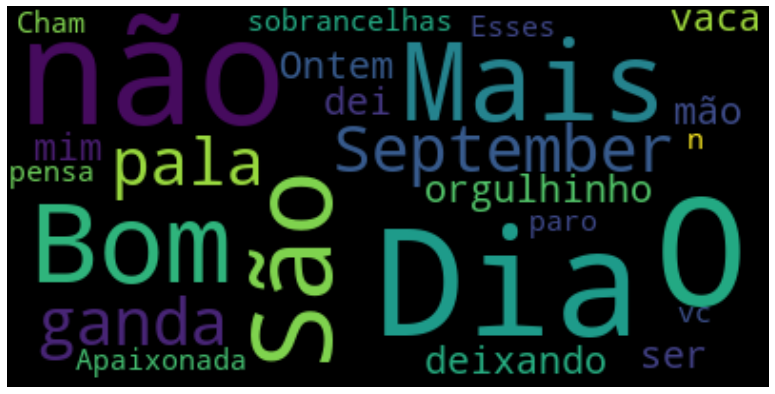

In [ ]:
# Nuvem de palavras dos tweets positivos
wc.generate(str(dados[dados.sentiment == "Positivo"].texto_final))
plt.figure(figsize=(20, 7))  # ajustar tamanho imagem
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

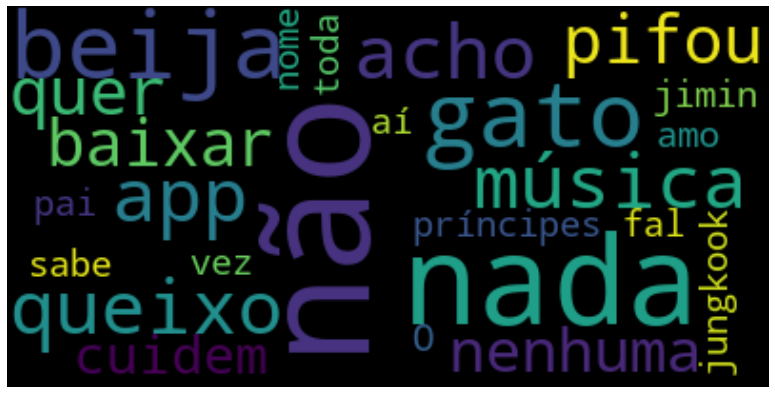

In [ ]:
# Nuvem de palavras dos tweets negativos
wc.generate(str(dados[dados.sentiment == "Negativo"].texto_final))
plt.figure(figsize=(20, 7))  # ajustar tamanho imagem
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

## 2. Modelagem: Usando todo o tratamento em modelos que só entendem números!

Todo este tratamento vem de um único detalhe: não importa qual modelo ou situação queremos trabalhar, computadores só entendem `números`!! E por conta disso, todo este trabalho de converter textos em palavras (e depois em contagens) faz sentido.

### 2.0 Separação treino-teste e escolha de métricas

Este problema é de `classificação`, então iremos escolher métricas próprias para esse tipo de problema. Como vimos antes, nosso problema tem relativamente bem distribuídas. Neste caso, podemos usar o `roc_auc` como uma boa métrica, pois estamos falando de um problema binário de classificação

<img src="https://i2.wp.com/sefiks.com/wp-content/uploads/2020/12/roc-curve-original.png?ssl=1">

Assim como em qualquer problema de machine learning, vamos separar os dados em `treino`e `teste`. Porém o método que usamos do `CountVectorizer`foi usado em todo o conjunto de dados. Que tipo de problemas isso pode gerar?

In [ ]:
# Separando os textos em features e targets
X = dados.texto_final
y = dados.sentiment

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234, stratify=y
)  # Random state para replicar código

Para evitar vazamento de dados, precisamos instanciar o `CountVectorizer` no conjunto de treino e aplicá-lo nos conjuntos de treino e de teste

In [ ]:
cv_train = CountVectorizer(
    strip_accents="unicode",  # Tratamento de acentos
    lowercase=True,  # Converte todos os caracteres em letras minúsculas
)

# Ajustando sobre os textos do treino
cv_train.fit(X_train)
# Aplicando sobre o treino e sobre o teste
X_train_vect = pd.DataFrame(cv_train.transform(X_train).todense())
X_test_vect = pd.DataFrame(cv_train.transform(X_test).todense())

### 2.1 Treinando um modelo de base

Com as bases trabalhadas, vamos agora treinar alguns modelos e avaliar suas performances

In [ ]:
modelos_teste = {
    "Logística": LogisticRegression(),
    "Árvore": DecisionTreeClassifier(max_depth=10),
    "RandomForest": RandomForestClassifier(max_depth=10),
    "LGBM": LGBMClassifier(),
}

In [ ]:
# Treinando cada modelo e avaliando métrica sobre conjuntos de validação
for nome, modelo in modelos_teste.items():
    metrica = cross_val_score(
        modelo, X_train_vect, y_train, cv=3, scoring="roc_auc"
    ).mean()
    print("ROC AUC - " + nome + ": {:.3f}".format(metrica))

ROC AUC - Logística: 0.775
ROC AUC - Árvore: 0.623
ROC AUC - RandomForest: 0.745
ROC AUC - LGBM: 0.743


Dos nossos modelos, o que melhor performou foi a `Regressão Logística`! E inclusive  muito melhor que um teste ao acaso, que seria de uma `ROC AUC` de `0.5` ou 50%.

Agora com nosso modelo escolhido, vamos otimizar os hiperparâmetros e plotar nosso modelo final! Para isso, vamos usar o `GridSearchCV` específico para a Regressão Logística

In [ ]:
param_grid = {"C": [0.01, 0.1, 1, 10, 100]}

rcv = GridSearchCV(
    LogisticRegression(),
    param_grid=param_grid,
    cv=3,
    scoring="roc_auc",
    verbose=True,
    n_jobs=8,
)
rcv.fit(X_train_vect, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  15 out of  15 | elapsed:   39.8s finished


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=8,
             param_grid={'C': [0.01, 0.1, 1, 10, 100]}, scoring='roc_auc',
             verbose=True)

In [ ]:
# Melhores parâmetros
print(rcv.best_params_)
# Treinando o modelo com melhores parâmetros
modelo_final = LogisticRegression(**rcv.best_params_).fit(X_train_vect, y_train)

# Avaliando a acurácia sobre o conjunto de teste
y_test_pred = modelo_final.predict_proba(X_test_vect)[:, 1]
acuracia_teste = roc_auc_score(y_test, y_test_pred)

print("Acurácia no conjunto de teste {:.3f}".format(acuracia_teste))

{'C': 1}
Acurácia no conjunto de teste 0.783


Parece que o modelo funcionou bem, mesmo no conjunto de teste! Mas será que podemos melhorar este modelo?

### 2.2 Feature Engineering com dados textuais

Assim como em qualquer problema de modelagem, podemos pensar em formas mais criativas de usar nossas features disponíveis e, a partir delas, criar novas features! Em caso de dados textuais não é diferente, e iremos agora discutir duas técnicas muito boas de criar novas features a partir das palavras/tokens que já separamos

### 2.2.1 N-gramas

No começo da nossa análise, separamos cada coluna como a contagem de cada palavra em cada texto. Mas há casos em que as palavras separadas não conseguem dar o mesmo contexto que teriam se contadas juntas. Vamos ver um exemplo:

* Avaliação 1: "Eu **não** gostei do meu dia hoje."
* Avaliação 2: "Amei, **não** consigo ver nenhum problema no rolê que fizemos!"

Qual é o significado da palavra `não` em cada caso?

Seria muito melhor se pudéssemos então agrupar os tokens em `pares`, certo? Assim a expressão `não gostei` realmente estaria mais presente em avaliações negativas, apesar da palavra `não` também ser possível em avaliações positivas

É nesse contexto que os `n-gramas` são muito úteis e podem nos ajudar! Os n-gramas nada mais são do que grupos de mais de uma palavra, lidos em uma `janela` que é o tamanho do n-grama. Sendo assim, `bigramas` são pares de palavras, `trigramas` triplas, e assim por diante.

<center> <img src="https://images.deepai.org/glossary-terms/867de904ba9b46869af29cead3194b6c/8ARA1.png" width=1200>

Para que passemos a considerar duas palavras nas features, podemos mudar este parâmetro na função `CountVectorizer`

In [ ]:
# Instanciando o objeto
cv_bigramas = CountVectorizer(
    strip_accents="unicode",  # Tratamento de acentos
    lowercase=True,  # Converte todos os caracteres em letras minúsculas
    ngram_range=(2, 2),  # Signfica tomar apenas pares de palavras (2)
)

# Treinando sobre o conjunto de treino
cv_bigramas.fit(dados.texto_final)
# Fazendo o processo de conversão em colunas efetivamente
frases_tratadas_bigram = cv_bigramas.transform(dados.texto_final)
df_frases_bigram = pd.DataFrame(frases_tratadas_bigram.todense())

In [ ]:
# Novo dicionário de vocabularios dos bigramas
mapa_vocabulario_bigram = {v: k for k, v in cv_bigramas.vocabulary_.items()}
df_frases_bigram.columns = df_frases_bigram.columns.map(mapa_vocabulario_bigram)

# Marcando a variável target, que é o sentimento do tweet
df_frases_bigram["sentimento_tweet"] = dados.sentiment

Vamos agora verificar os pares de palavras mais frequentes novamente, sobre os sentimentos positivos e negativos

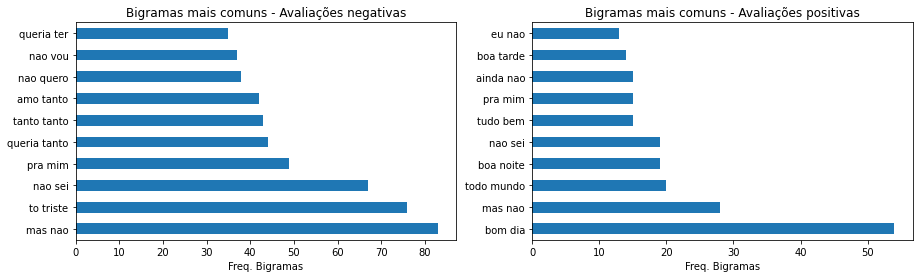

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
cols_bigramas = df_frases_bigram.columns[:-1]
df_frases_bigram[df_frases_bigram.sentimento_tweet == "Negativo"][
    cols_bigramas
].sum().sort_values(ascending=False)[:10].plot(kind="barh", ax=ax[0])
df_frases_bigram[df_frases_bigram.sentimento_tweet == "Positivo"][
    cols_bigramas
].sum().sort_values(ascending=False)[:10].plot(kind="barh", ax=ax[1])
ax[0].set_xlabel("Freq. Bigramas")
ax[1].set_xlabel("Freq. Bigramas")
ax[1].set_title("Bigramas mais comuns - Avaliações positivas")
ax[0].set_title("Bigramas mais comuns - Avaliações negativas")
plt.show()

Dessa vez, temos termos que indicam melhor sentimentos positivos e negativos. Quais exemplos vocês conseguem ver?

Vamos agora retreinar nosso modelo usando apenas os bigramas, e avaliar nossa performance

In [ ]:
cv_bigramas = CountVectorizer(
    strip_accents="unicode",  # Tratamento de acentos
    lowercase=True,  # Converte todos os caracteres em letras minúsculas
    ngram_range=(1, 2),  # Considerando palavras E bigramas
)

# Ajustando sobre os textos do treino
cv_bigramas.fit(X_train)
# Aplicando sobre o treino e sobre o teste
X_train_bigramas = pd.DataFrame(cv_bigramas.transform(X_train).todense())
X_test_bigramas = pd.DataFrame(cv_bigramas.transform(X_test).todense())

Vamos comparar as Regressões Logísticas usando unigramas (palavras) e bigramas

In [ ]:
print(
    "Performance usando unigramas, ou palavras: {:.3f}".format(
        cross_val_score(
            LogisticRegression(), X_train_vect, y_train, scoring="roc_auc", cv=3
        ).mean()
    )
)
print(
    "Performance usando unigramas e bigramas: {:.3f}".format(
        cross_val_score(
            LogisticRegression(), X_train_bigramas, y_train, scoring="roc_auc", cv=3
        ).mean()
    )
)

Performance usando unigramas, ou palavras: 0.775
Performance usando unigramas e bigramas: 0.779


O que podemos concluir?

### 2.2.2 Eliminando a frequência de palavras comuns com TF-IDF

Apesar de conseguimos melhores resultados usando unigramas, ainda temos algumas palavras muito comuns e frequentes pelo assunto do Dataset (como `não`). Desta forma, ela não é tão importante assim para diferenciar tweets positivos e negativas.

E se pudéssemos usar `apenas palavras realmente relevantes` para construir nosso Dataset? Podemos fazer isso usando o 
`TF-IDF` (Text Freqency - Inverted Document Frequency)

<center> <img src="https://miro.medium.com/max/1404/1*mu6G-cBmWlENS4pWHEnGcg@2x.jpeg" width=800>
  

Para usar o TFIDF, podemos usar a função `TfidfVectorizer` do `scikit-learn`

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instanciando o objeto
tfidf = TfidfVectorizer(
    strip_accents="unicode",  # Tratamento de acentos
    lowercase=True,  # Converte todos os caracteres em letras minúsculas
    ngram_range=(2, 2),  # Incluindo apenas bigramas
)

# Ajustando sobre os dados
tfidf.fit(X_train)
# Fazendo o processo de conversão em colunas efetivamente
frases_tratadas_tfidf = tfidf.transform(X_train)
df_frases_tfidf = pd.DataFrame(frases_tratadas_tfidf.todense())

Assim como nos outros casos, vamos marcar os nomes das colunas e analisar os termos mais frequentes

In [ ]:
# Novo dicionário de vocabularios dos bigramas
mapa_vocabulario_tfidf = {v: k for k, v in tfidf.vocabulary_.items()}
df_frases_tfidf.columns = df_frases_tfidf.columns.map(mapa_vocabulario_tfidf)
# Marcando a variável target, que é o sentimento do tweet
df_frases_tfidf["sentimento_tweet"] = dados.sentiment

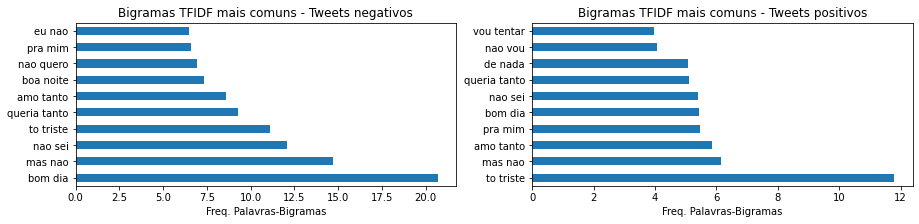

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
cols_tfidf = df_frases_tfidf.columns[:-1]
df_frases_tfidf[df_frases_tfidf.sentimento_tweet == "Negativo"][
    cols_tfidf
].sum().sort_values(ascending=False)[:10].plot(kind="barh", ax=ax[0])
df_frases_tfidf[df_frases_tfidf.sentimento_tweet == "Positivo"][
    cols_tfidf
].sum().sort_values(ascending=False)[:10].plot(kind="barh", ax=ax[1])
ax[0].set_xlabel("Freq. Palavras-Bigramas")
ax[1].set_xlabel("Freq. Palavras-Bigramas")
ax[1].set_title("Bigramas TFIDF mais comuns - Tweets positivos")
ax[0].set_title("Bigramas TFIDF mais comuns - Tweets negativos")
plt.show()

Com TFIDF, conseguimos ver mais claramente termos associados a avaliações positivas e negativas, mas sem tantas repetições com a palavra `não`, como vimos no caso de tratamento de bigramas. Quais expressões passaram a aparecer?

Para finalizar, vamos comparar agora o modelo com TFIDF com os dois anteriores que treinamos, usando `unigramas` e `bigramas`:

In [ ]:
tfidf_final = TfidfVectorizer(
    strip_accents="unicode",  # Tratamento de acentos
    lowercase=True,  # Converte todos os caracteres em letras minúsculas
    ngram_range=(1, 2),  # Incluindo unigramas e bigramas
)

# Ajustando sobre os textos do treino
tfidf_final.fit(X_train)
# Aplicando sobre o treino e sobre o teste
X_train_tfidf = pd.DataFrame(tfidf_final.transform(X_train).todense())
X_test_tfidf = pd.DataFrame(tfidf_final.transform(X_test).todense())

In [ ]:
print(
    "Performance usando unigramas, ou palavras: {:.3f}".format(
        cross_val_score(
            LogisticRegression(), X_train_vect, y_train, scoring="roc_auc", cv=3
        ).mean()
    )
)
print(
    "Performance usando unigramas e bigramas: {:.3f}".format(
        cross_val_score(
            LogisticRegression(), X_train_bigramas, y_train, scoring="roc_auc", cv=3
        ).mean()
    )
)
print(
    "Performance usando TFIDF de unigramas e bigramas: {:.3f}".format(
        cross_val_score(
            LogisticRegression(), X_train_tfidf, y_train, scoring="roc_auc", cv=3
        ).mean()
    )
)

Performance usando unigramas, ou palavras: 0.775
Performance usando unigramas e bigramas: 0.779
Performance usando TFIDF de unigramas e bigramas: 0.788


Os tratamentos funcionaram!

## 3. Indo além: Representações vetoriais de palavras com Embeddings

Agora que já sabemos como tratar textos em features, vamos dar um passo além e representar nossas palavras como vetores

### 3.0 Tentando resolver os problemas do `bag of words`

Mesmo durante nossas soluções, fica bem claro que em qualquer abordagem de `bag of words` criamos **milhares de colunas**, e isso gera tanto problemas de `memória` quanto de `interpretabilidade` das bases criadas!

In [ ]:
df_frases.head()

,00,000,00155a7d,00am,00pm,01,01h,03,032f6ace6b16,040,...,zona,zoo,zootopia,zuado,zuando,zuckerberg,zuou,ᅠᅠᅠᅠᅠᅠ,ゝeu,sentimento_tweet
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negativo
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negativo
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positivo
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negativo
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negativo


Seria muito mais conveniente se pudéssemos representar cada palavra por um `vetor de números`, de forma que as dimensões da base final fossem menores

<center> <img src="../2. MISC/embeddings.png" width=400>

Este é o famoso conceito de `embeddings`, onde os significados estão 'embebidos' dentro de um número menor de dimensões. Assim, um vasto vocabulário poderá ser representado por vetores, com cada dimensão carregando um significado instríseco (ex: gênero, plural, tipo, tamanho)

Para encontrarmos esse 'novo espaço' de menos dimensões sobre a qual podemos descrever nossas palavras, precisamos de algum método que permita que algum modelo aprenda essas dimensões. Uma das formas mais conhecidas de se fazer esse mapeamento é usando novas estruturas de dados chamados `cbow`, ou `context bag of words`

<center> <img src="https://1.bp.blogspot.com/-nZFc7P6o3Yc/XQo2cYPM_ZI/AAAAAAAABxM/XBqYSa06oyQ_sxQzPcgnUxb5msRwDrJrQCLcBGAs/s1600/image001.png" width=500>

Neste algoritmo, organizamos as palavras de forma tal que o modelo tentará prever a palavra central com base nas palavras do seu entorno ou contexto

In [ ]:
frase_exemplo = "Eu vou para a minha casa hoje"

# Com uma janela de 3 palavras
target1 = "vou"
features1 = ("Eu", "para")

target2 = "para"
features2 = ("vou", "minha")

target3 = "minha"
features3 = ("para", "casa")

Sendo assim, o `contexto` das palavras dirá qual palavra provavelmente temos na frase!

### 3.1 Treinando embeddings com o  `word2vec`

O modelo que permite esse tipo de treinamento para nós é uma `rede neural`, mas diferente do que pensamos, já há muitas implementações simples que podemos usar sem mesmo ter muito conhecimento de redes neurais. Uma bem famosa é o `Word2Vec`, que usaremos aqui!

<center> 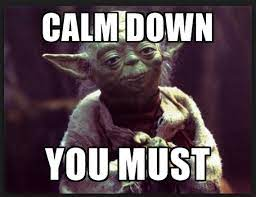

Mas calma, se você nunca viu ou não conhece redes neurais, não tem problema, a ideia é mostrar como é fácil aplicar estes conceitos na prática

In [ ]:
from gensim.models import Word2Vec

Para usar um `Word2Vec`, só precisamos especificar o tamanho das dimensões que queremos, a janela de leitura dos textos e o número mínimo de ocorrências de uma palavra para ela ser considerada relevante para o processo

In [ ]:
# Treinando um Word2Vec
wv = Word2Vec(
    sentences=dados.texto_final.apply(
        lambda x: x.split()
    ).values,  # Relação de sentenças/frases
    vector_size=10,  # Dimensão final do embedding (i.e. número de colunas da representação)
    window=3,  # Janela de contexto que consideraremos para tentar prever a palavra central
    min_count=1,  # Número mínimo de ocorrências de uma palavra para ela ser considerada no modelo
    workers=10,  # Número de processadores usados
)

### 3.2 Funcionalidades do  `word2vec`

Agora que podemos representar cada token na forma de vetores, podemos comparar as palavras entre sí usando a função `most_similar`do objeto `Word2Vec` treinado

In [ ]:
wv.wv.most_similar("triste")

[('feliz', 0.99249267578125),
 ('ficar', 0.9918792843818665),
 ('sei', 0.9916536808013916),
 ('saber', 0.990849494934082),
 ('q', 0.990795373916626),
 ('assistir', 0.9907591342926025),
 ('vou', 0.9903814792633057),
 ('ir', 0.9902487993240356),
 ('vai', 0.9896280765533447),
 ('lindo', 0.989183783531189)]

Também podemos representar cada `tweet` como um vetor único, usando os embeddings para isso! Para facilitar este trabalho, vamos construir uma função que transforme cada palavra de um tweet em um vetor, usando a função `get_vector()`

In [ ]:
wv.wv.get_vector("triste")

array([ 0.10348392, -0.5523751 ,  0.34502307, -0.38665354,  0.60542697,
        0.27420875,  1.326015  ,  0.43546572, -0.9825272 , -0.32693192],
      dtype=float32)

Com isso, podemos criar uma função que transforma uma palavra em um vetor de representaço, usando para isso nosso `Word2Vec`

In [ ]:
def transforma_palavra(tweet):
    # Define dicionário para abrigar os vetores de palavras
    dict_vetores = {}
    # Usando a função get_vector, transforma a palavra no vetor de Embeddings
    for palavra in tweet.split():
        dict_vetores[palavra] = wv.wv.get_vector(palavra)
    return dict_vetores

Testando agora sobre o primeiro `tweet`

In [ ]:
transforma_palavra(dados.texto_final[0])

{'gato': array([ 0.13184454, -0.1897148 ,  0.00212807, -0.02304993,  0.0369725 ,
         0.10777054,  0.21385248,  0.02589419, -0.1542374 , -0.05754994],
       dtype=float32),
 'beija': array([-0.04136916, -0.09973264, -0.05450664, -0.01320821,  0.029126  ,
         0.12166975,  0.16990489,  0.09070545, -0.01597275,  0.02372941],
       dtype=float32),
 'queixo': array([ 0.05380009, -0.0639279 , -0.07337564, -0.0178093 ,  0.07594086,
         0.04515729,  0.06329644, -0.04196674, -0.05858269,  0.07150318],
       dtype=float32),
 'nada': array([ 0.24800093, -0.7714271 ,  0.6088711 , -0.55854315,  1.0398217 ,
         0.38227573,  1.5306833 ,  0.6090234 , -1.5466162 , -0.64445025],
       dtype=float32)}

Agora que sabemos converter uma palavra em um vetor, podemos converter `todo o tweet` e representá-lo como um único vetor! Temos algumas formas de sumarizar os vetores de cada palavra, e para este exemplo vamos usar a média:

In [ ]:
def transforma_tweet(tweet):
    # Usando a função get_vector, transforma a palavra no vetor de Embeddings
    lista_vetores = [wv.wv.get_vector(x) for x in tweet.split()]
    return np.sum(lista_vetores, axis=0)

Com essa função criada, vamos aplicá-la com o método `.apply()` do Pandas ao nosso DataFrame original

In [ ]:
# Aplicando sobre os nossos tweets
vetores_embeddings = dados.texto_final.apply(transforma_tweet)

# Criando um Dataframe com os resultados
df_embeddings = pd.DataFrame.from_dict(
    dict(zip(vetores_embeddings.index, vetores_embeddings.values))
).T
# Definindo os nomes das colunas
df_embeddings.columns = ["embedding_" + str(i) for i in range(1, 11)]

# Vamos também trazer o tweet original e o sentimento
df_embeddings["tweet"] = dados.texto_final
df_embeddings["sentimento_tweet"] = dados.sentiment

df_embeddings.head()

,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,tweet,sentimento_tweet
0,0.392276,-1.124802,0.483117,-0.612611,1.181861,0.656873,1.977737,0.683656,-1.775409,-0.606768,gato beija queixo nada,Negativo
1,1.275719,-3.353176,2.104879,-2.144978,3.764331,1.292598,6.545410,3.052709,-6.270268,-2.478683,acho app música pifou não quer baixar nenhuma,Negativo
2,1.409090,-3.437270,2.773641,-1.744473,3.114618,1.179414,5.451665,3.036403,-5.503507,-1.870184,Bom Dia Mais Dia São September 24 2018 at 07:3...,Positivo
3,0.387580,-1.083244,0.297804,-0.369639,0.920514,0.264785,1.362826,0.647262,-1.628318,-0.382639,cuidem príncipes amo,Negativo
4,5.080564,-11.936690,9.328081,-7.408183,13.143221,5.371646,23.933271,11.459881,-23.710945,-9.444567,O pai sabe nome jungkook jimin aí toda vez fal...,Negativo


### 3.3 Treinando um modelo com embeddings

Agora que temos todos os `tweets` representados na forma de vetores, podemos usar novamente alguns modelos para avaliar qual deles prevê melhor o sentimento de cada tweet

In [ ]:
# Separando os dados em X e y
X_emb = df_embeddings[df_embeddings.columns[:10]]
y_emb = df_embeddings.sentimento_tweet

X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(
    X_emb, y_emb, test_size=0.2, stratify=y_emb
)

In [ ]:
modelos_teste = {
    "Logística": LogisticRegression(),
    "Árvore": DecisionTreeClassifier(max_depth=10),
    "RandomForest": RandomForestClassifier(max_depth=10),
    "LGBM": LGBMClassifier(),
}

# Treinando cada modelo e avaliando métrica sobre conjuntos de validação
for nome, modelo in modelos_teste.items():
    metrica = cross_val_score(
        modelo, X_train_emb, y_train_emb, cv=3, scoring="roc_auc"
    ).mean()
    print("ROC AUC - " + nome + ": {:.3f}".format(metrica))

ROC AUC - Logística: 0.718
ROC AUC - Árvore: 0.653
ROC AUC - RandomForest: 0.702
ROC AUC - LGBM: 0.709


Não conseguimos superar uma performance mais simples como a da Regressão Logística usando Bag of Words, mas até que faz sentido, dado que 'comprimimos' a informação de todas as sentenças em apenas 10 dimensões. 

## 4. Conclusões!

Falamos bastante coisa sobre análise de textos! 
Para ajudar, vamos relembrar as principais técnicas que aprendemos:

<center> <img src="https://i.gifer.com/2jv.gif" width=1200>

* Textos são sequências de palavras, e para interpretá-los como features, uma das técnicas mais utilizadas é considerar `n-gramas` de palavras (conjuntos de uma, duas, três palavras, etc. como elementos isolados
* Vimos duas formas diferentes de tratar n-gramas: contando as ocorrências de palavras em cada frase/tweet usando o `CountVectorizer` ou também considerando a frequência relativa de cada palavra em todo o dataset com o `TfidfVectorizer`. Ambos são abordagens do estilo `bag of words` ('saco' de palavras) e pertencem ao pacote `NLTK`
* Há diversos tratamentos que podemos fazer para tratar textos, como remover `stopwords` (palavras comuns e não importantes para o significado), pontuações e até mesmo extrair apenas o núcleo de cada palavra com o `Stemming`
* Podemos também criar representações vetoriais de palavras e até mesmo de tweets usando `word embeddings`, que são algoritmos de Redes Neurais que capturam significados de palavras similares; com eles, podemos treinar novos modelos ou até mesmo reduzir a dimensionalidade do nosso dataset

## 5. Algumas referências interessantes

* Em NLP temos diversas bibliotecas disponíveis, não apenas o `NLTK`, segue a documentação de algumas delas:
 * [Gensim](https://radimrehurek.com/gensim/auto_examples/index.html) -> Útil para embeddings e topic modelling
 * [spaCy](https://spacy.io/) -> Funções parecidas com a do NLTK, com módulos mais refinados de stopwords e NER
 * [TextBlob](https://textblob.readthedocs.io/en/dev/) -> Representação gráfica de textos
 
* Não discutimos profundamente RegEx aqui porque é um assunto que é mais treino do que exposição, então vale mais a pena treinar em alguns sites legais para isso ou usar sempre que necessário. Sugiro colocar esses links na sua barra de favoritos!:
 * https://regexr.com/
 * https://www.regextester.com/
* Este guia [aqui](https://towardsdatascience.com/word-embeddings-intuition-behind-the-vector-representation-of-the-words-7e4eb2410bba) é uma ótima introdução para o entendimento do que são embeddings e de como são treinados em redes neurais
* Para quem tem interesse em se aprofundar neste assunto, há grupos de pesquisa universitários que estão trabalhando em Chatbots no estado da arte. Este grupo da iniciativa [C4AI](https://c4ai.inova.usp.br/pt/keml-pt/) da USP está construindo chatbots de perguntas e respostas baseados em embeddings não muito diferentes dos que vimos

# <center> Muito obrigado a todos!!!